In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle


print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# data = pd.read_parquet('../kaggle/input/cord-ner-full.parquet.gzip')
data = pd.read_csv('../kaggle/input/covid_subset_3perc.csv')
data

,word,entity,sentence
0,angiotensin-converting,B-GENE_OR_GENOME,0
1,enzyme,I-GENE_OR_GENOME,0
2,2,I-GENE_OR_GENOME,0
3,ace2,B-GENE_OR_GENOME,0
4,as,Other,0
...,...,...,...
1511829,messages,Other,3999
1511830,emerged.,Other,3999
1511831,first,B-ORDINAL,3999
1511832,policymakers,Other,3999


In [3]:
print(f"Number of unique entities: {len(data['entity'].unique())}")
data['entity'].unique()

Number of unique entities: 123


array(['B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'Other', 'B-CORONAVIRUS',
       'B-CHEMICAL', 'B-EVOLUTION', 'B-WILDLIFE', 'B-NORP', 'I-NORP',
       'B-ORGANISM', 'B-EUKARYOTE', 'B-PERSON', 'I-PERSON',
       'B-PHYSICAL_SCIENCE', 'I-PHYSICAL_SCIENCE', 'I-CHEMICAL',
       'B-DISEASE_OR_SYNDROME', 'I-DISEASE_OR_SYNDROME', 'I-ORGANISM',
       'B-DATE', 'B-CARDINAL', 'B-MOLECULAR_FUNCTION',
       'B-EXPERIMENTAL_MODEL_OF_DISEASE',
       'I-EXPERIMENTAL_MODEL_OF_DISEASE', 'B-CELL',
       'B-BODY_PART_ORGAN_OR_ORGAN_COMPONENT', 'B-LIVESTOCK', 'B-ORG',
       'B-TISSUE', 'I-TISSUE', 'B-GROUP', 'I-CELL', 'B-CELL_COMPONENT',
       'I-CELL_COMPONENT', 'B-FOOD', 'B-CELL_FUNCTION', 'I-DATE', 'B-GPE',
       'B-DAILY_OR_RECREATIONAL_ACTIVITY', 'B-BODY_SUBSTANCE',
       'B-INDIVIDUAL_BEHAVIOR', 'B-GOVERNMENTAL_OR_REGULATORY_ACTIVITY',
       'B-ORDINAL', 'B-LABORATORY_PROCEDURE', 'I-LABORATORY_PROCEDURE',
       'B-VIRUS', 'B-PRODUCT', 'B-SIGN_OR_SYMPTOM',
       'B-LABORATORY_OR_TEST_RESUL

In [4]:
words = list(set(data['word'].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data['entity'].values))
num_tags = len(tags)

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['entity'].values.tolist())]
        self.grouped = self.data.groupby('sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Init SentenceGetter object to preprocess and parse dataset into separate sentences
# 'sentences' object is an array of arrays, which contains tuples of word-entity pairs
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:1]

[[('angiotensin-converting', 'B-GENE_OR_GENOME'),
  ('enzyme', 'I-GENE_OR_GENOME'),
  ('2', 'I-GENE_OR_GENOME'),
  ('ace2', 'B-GENE_OR_GENOME'),
  ('as', 'Other'),
  ('a', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('receptor', 'B-CHEMICAL'),
  ('molecular', 'Other'),
  ('mechanisms', 'Other'),
  ('and', 'Other'),
  ('potential', 'Other'),
  ('therapeutic', 'Other'),
  ('target', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('has', 'Other'),
  ('been', 'Other'),
  ('sequenced', 'Other'),
  ('[3]', 'Other'),
  ('.', 'Other'),
  ('a', 'Other'),
  ('phylogenetic', 'B-EVOLUTION'),
  ('analysis', 'Other'),
  ('[3,', 'Other'),
  ('4]', 'Other'),
  ('found', 'Other'),
  ('a', 'Other'),
  ('bat', 'B-WILDLIFE'),
  ('origin', 'Other'),
  ('for', 'Other'),
  ('the', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('there', 'Other'),
  ('is', 'Other'),
  ('a', 'Other'),
  ('diversity', 'Other'),
  ('of', 'Other'),
  ('possible', 'Other'),
  ('intermediate', 'B-NORP'),
  ('hosts', 'I-NORP'),
 

In [6]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = data.groupby(['sentence'], sort=False).size().max()

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['Other'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Transformer block and NER model creation

In [7]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(
            tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        key = tf.reshape(
            tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        value = tf.reshape(
            tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )

        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.reshape(
            tf.transpose(tf.reshape(output, (batch_size, self.num_heads, -1, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size, -1, self.embed_dim),
        )
        output = self.combine_heads(output)
        return output

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
#         self.att = keras.layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=embed_dim
#         )
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
#         out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(inputs + ffn_output)

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [10]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32, num_layers=1, rate=0.1
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#         self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.ff_final(x)
        return x

In [11]:
with strategy.scope():
    learning_rate = 0.0008
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    ner_model = NERModel(num_tags, len(words), embed_dim=128, num_heads=2, ff_dim=num_tags*4, num_layers=2, rate=0.2)
    ner_model.compile(optimizer=optimizer, 
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
    history = ner_model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        batch_size=int(max_len/4),
        epochs=8,
        verbose=1
    )

Epoch 1/8
23/23 [==============================] - 5s 127ms/step - loss: 1.1180 - accuracy: 0.8073 - val_loss: 0.6673 - val_accuracy: 0.8724
Epoch 2/8
23/23 [==============================] - 2s 101ms/step - loss: 0.5722 - accuracy: 0.8790 - val_loss: 0.4961 - val_accuracy: 0.8905
Epoch 3/8
23/23 [==============================] - 2s 101ms/step - loss: 0.4595 - accuracy: 0.8945 - val_loss: 0.4435 - val_accuracy: 0.8965
Epoch 4/8
23/23 [==============================] - 2s 101ms/step - loss: 0.3948 - accuracy: 0.9029 - val_loss: 0.4198 - val_accuracy: 0.8987
Epoch 5/8
23/23 [==============================] - 2s 102ms/step - loss: 0.3637 - accuracy: 0.9063 - val_loss: 0.4057 - val_accuracy: 0.8997
Epoch 6/8
23/23 [==============================] - 2s 102ms/step - loss: 0.3411 - accuracy: 0.9092 - val_loss: 0.4002 - val_accuracy: 0.9001
Epoch 7/8
23/23 [==============================] - 2s 103ms/step - loss: 0.3212 - accuracy: 0.9125 - val_loss: 0.4081 - val_accuracy: 0.8970
Epoch 8/8
23/

In [12]:
ner_model.save('../models/model_cord_transformer/model.tf')

with open('../models/model_cord_transformer/history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../models/model_cord_transformer/maxlen.pickle', 'wb') as handle:
    pickle.dump(max_len, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_cord_transformer/tags.pickle', 'wb') as handle:
    pickle.dump(tags, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_cord_transformer/words.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# new_model = keras.models.load_model('../models/model_cord_transformer/model.tf')

INFO:tensorflow:Assets written to: ../models/model_cord_transformer/model.tf\assets


INFO:tensorflow:Assets written to: ../models/model_cord_transformer/model.tf\assets


In [13]:
def plot_history(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

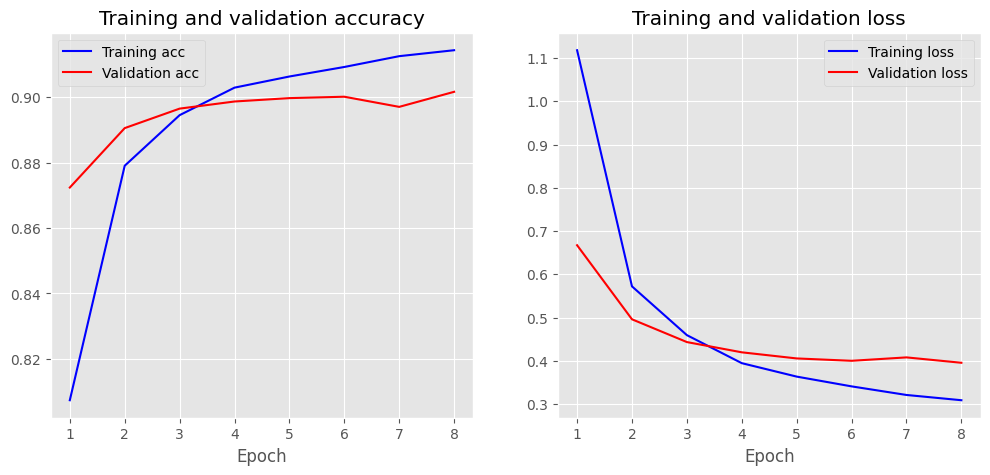

In [14]:
plot_history(history)

In [15]:
for i in range(3):
    p = ner_model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        if words[w] == "ENDPAD":
            break
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    print("----------------------------")

1/1 [==============================] - 1s 547ms/step
Word           True 	 Pred

------------------------------
middle         B-CORONAVIRUS	B-CORONAVIRUS
east           I-CORONAVIRUS	I-CORONAVIRUS
respiratory    I-CORONAVIRUS	I-CORONAVIRUS
syndrome       I-CORONAVIRUS	I-CELL_COMPONENT
coronavirus    I-CORONAVIRUS	B-CORONAVIRUS
mers-cov       B-CORONAVIRUS	B-CORONAVIRUS
neutralising   Other	Other
antibodies     Other	B-CHEMICAL
in             Other	Other
a              Other	Other
high-risk      Other	Other
human          B-ORGANISM	B-ORGANISM
population,    Other	Other
morocco        B-GPE	B-CHEMICAL
november       B-DATE	B-DATE
2017           I-DATE	B-DATE
to             I-DATE	Other
january        I-DATE	B-DATE
2018           I-DATE	B-DATE
the            Other	Other
middle         B-CORONAVIRUS	Other
east           I-CORONAVIRUS	I-CORONAVIRUS
respiratory    I-CORONAVIRUS	I-CORONAVIRUS
syndrome       I-CORONAVIRUS	I-CORONAVIRUS
coronavirus    I-CORONAVIRUS	B-CORONAVIRUS
mers-cov     

1/1 [==============================] - 0s 63ms/step
Word           True 	 Pred

------------------------------
not            Other	Other
present        Other	Other
to             Other	Other
medical        Other	Other
authorities    B-SOCIAL_BEHAVIOR	B-SOCIAL_BEHAVIOR
in             Other	Other
other          Other	Other
words,         Other	Other
they           Other	Other
spend          Other	Other
the            Other	Other
remainder      Other	Other
of             Other	Other
their          Other	Other
infectious     B-GENE_OR_GENOME	B-GENE_OR_GENOME
period         I-GENE_OR_GENOME	Other
mixing         Other	Other
in             Other	Other
the            Other	Other
community.     Other	Other
on             Other	Other
the            Other	Other
other          Other	Other
hand,          Other	Other
the            Other	Other
'presymptomatic'Other	Other
infected       Other	Other
arrivals,      Other	Other
including      Other	Other
all            Other	Other
individuals    Other	

1/1 [==============================] - 0s 71ms/step
Word           True 	 Pred

------------------------------
declared       Other	Other
in             Other	Other
the            Other	Other
statement      Other	Other
regarding      Other	Other
the            Other	Other
outbreak       Other	Other
of             Other	Other
sars-cov-2     B-CORONAVIRUS	B-CORONAVIRUS
dated          Other	Other
23th           B-PERSON	Other
january        I-PERSON	B-DATE
2020           I-PERSON	I-DATE
7              Other	Other
however,       Other	Other
several        Other	Other
published      Other	Other
studies        Other	Other
aimed          Other	Other
to             Other	Other
precisely      Other	Other
estimate       Other	Other
the            Other	Other
covid-19       B-CORONAVIRUS	B-CORONAVIRUS
r0.            Other	Other
a              Other	Other
recent         Other	Other
review         Other	Other
written        Other	Other
by             Other	Other
liu            B-CELL	B-CELL
et     